<a href="https://colab.research.google.com/github/hasune613/hello-world/blob/main/Optuna_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive

MyDrive


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
train_raw =pd.read_csv('/content/drive/MyDrive/kaggle/train.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/kaggle/test.csv')
print('The size of the train data' +str(train_raw.shape))
print('The size of the test  data' +str(test_raw.shape))

train_mid = train_raw.copy()
test_mid = test_raw.copy()
train_mid['train_or_test'] = 'train' #学習データフラグ
test_mid['train_or_test'] = 'test' #テストデータフラグ
test_mid['Survived'] = 9#テストにSurvivedカラムを仮置き
# train_mid.shape, test_mid.shape
# train_mid.head(1)
# test_mid.head(1)

alldata = pd.concat([train_mid, test_mid],sort=False, axis = 0).reset_index(drop=True)
alldata.head(1)
print('The size of the alldata data' + str(alldata.shape))
# alldata.head(1)



The size of the train data(891, 12)
The size of the test  data(418, 11)
The size of the alldata data(1309, 13)


In [ ]:
#欠損値補完
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       1309 non-null   int64  
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1046 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1307 non-null   object 
 12  train_or_test  1309 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 133.1+ KB


In [ ]:
alldata.isnull().sum()
#Age 263/Fare 1/Cabin 1014/Embarked 2/

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
train_or_test       0
dtype: int64

In [ ]:
alldata.Embarked.mode()[0]

'S'

In [ ]:
#Embarkedを最頻値で補完
alldata.Embarked.fillna(alldata.Embarked.mode()[0],inplace=True)
#Fareを中央値で補完
alldata.Fare.fillna(alldata.Fare.median(),inplace=True)
print(alldata.isnull().sum())

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin            1014
Embarked            0
train_or_test       0
dtype: int64


In [ ]:
#FamilySize = SibSp(兄弟,配偶者の数) + Parch(両親、子供の数) )
alldata['FamilySize'] = alldata['SibSp']+alldata['Parch'] +1
# FamilySizeを離散化
alldata['FamilySize_bin'] = 'big'
alldata.head()
alldata.loc[alldata['FamilySize'] ==1,'FamilySize_bin'] = 'alone'
alldata.loc[(alldata['FamilySize'] >=2) &(alldata['FamilySize']<=4),'FamilySize_bin'] = 'small'
alldata.loc[(alldata['FamilySize'] >=4) &(alldata['FamilySize']<=7),'FamilySize_bin'] ='median'

# alldata.head(10)

In [ ]:
#同じTicket(チケット番号)を出現頻度として特徴量とする
# len(alldata.Ticket.unique())
# len(alldata.Ticket)
alldata.loc[:,'TicketFreq'] = alldata.groupby(['Ticket'])['PassengerId'].transform('count')


In [ ]:
#Nameの敬称を特徴量とする
# alldata['honorific'] = alldata['Name'].map(lambda x : x.split('.')[1].split('.')[0]) 
# alldata[['honorific','Name']]
#敬称(honorific)の加工
# alldata['honorific'].replace(['Col', 'Dr', 'Rev'],'Rare',inplace = True)
# alldata['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
# alldata['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合

In [ ]:
# sample = "a b c d e f"
# print(sample.split(' ', 4))
# print(sample.split(' ',4)[3])
# print(sample.split(' ', 1)[1])

In [ ]:
#Nameの敬称を特徴量とする
alldata['honorific'] =alldata.Name.str.extract('([A-Za-z]+)\.',expand=False)

In [ ]:
alldata.Name.str.extract('([A-Za-z]+\.)',expand=False).value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Dr.            8
Rev.           8
Col.           4
Major.         2
Mlle.          2
Ms.            2
Capt.          1
Sir.           1
Jonkheer.      1
Dona.          1
Countess.      1
Don.           1
Mme.           1
Lady.          1
Name: Name, dtype: int64

In [ ]:
alldata['honorific'].replace(['Col','Dr','Rev'],'Rare',inplace = True)
# print((alldata.honorific=='Col').sum())#0
# print((alldata.honorific=='Dr').sum())#0
# print((alldata.honorific=='Rev').sum())#0
# print((alldata.honorific=='Rare').sum())#20
alldata['honorific'].replace('Mlle','Miss',inplace=True)#MlleをMissに統合
# print((alldata['honorific']=='Mlle').sum())#0
# print((alldata['honorific']=='Miss').sum())#262
alldata['honorific'].replace('Ms','Miss',inplace=True)#MsをMissに統合
# print((alldata['honorific']=='Ms').sum())
# print((alldata['honorific']=='Miss').sum())#264


In [ ]:
# Fareの分割(外れ値対応)
alldata.loc[:,'Fare_bin'] = pd.qcut(alldata.Fare,14)
# Cabin(頭文字を特徴量とする)
alldata['Cabin_ini'] = alldata['Cabin'].map(lambda x : str(x)[0])
alldata['Cabin_ini'].replace(['G','T'],'Rare',inplace=True)#少数派のCabin_iniを統合
# print((alldata['Cabin_ini']=='G').sum())#0
# print((alldata['Cabin_ini']=='G').sum())#0
# print((alldata['Cabin_ini']=='Rare').sum())#6

In [ ]:
# Encoding
alldata.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
train_or_test       object
FamilySize           int64
FamilySize_bin      object
TicketFreq           int64
honorific           object
Fare_bin          category
Cabin_ini           object
dtype: object

In [ ]:
alldata.Pclass = alldata.Pclass.astype('str')
alldata.dtypes

PassengerId          int64
Survived             int64
Pclass              object
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
train_or_test       object
FamilySize           int64
FamilySize_bin      object
TicketFreq           int64
honorific           object
Fare_bin          category
Cabin_ini           object
dtype: object

In [ ]:
# SexとFare_binをLabel Encoding
# 外れ値対策後のalldata.Fare_binには’(’や’[’が含まれているのでのちにエラーとなる
le_target_col = ['Sex','Fare_bin']
le = LabelEncoder()
for col in le_target_col:
    # print(alldata[col])
    alldata.loc[:,col] = le.fit_transform(alldata[col])#fit_transformメソッドの戻り値は ndarray 
# alldata.head()

In [ ]:
alldata.dtypes

PassengerId         int64
Survived            int64
Pclass             object
Name               object
Sex                 int64
Age               float64
SibSp               int64
Parch               int64
Ticket             object
Fare              float64
Cabin              object
Embarked           object
train_or_test      object
FamilySize          int64
FamilySize_bin     object
TicketFreq          int64
honorific          object
Fare_bin            int64
Cabin_ini          object
dtype: object

In [ ]:
#カテゴリカル変数をOne-Hot Encoding
cat_col = ['Pclass','Embarked','honorific','Cabin_ini','FamilySize_bin','Fare_bin']
alldata = pd.get_dummies(alldata,drop_first=True,columns=cat_col)


In [ ]:
alldata.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'train_or_test', 'FamilySize', 'TicketFreq',
       'Pclass_2', 'Pclass_3', 'Embarked_Q', 'Embarked_S',
       'honorific_Countess', 'honorific_Don', 'honorific_Dona',
       'honorific_Jonkheer', 'honorific_Lady', 'honorific_Major',
       'honorific_Master', 'honorific_Miss', 'honorific_Mme', 'honorific_Mr',
       'honorific_Mrs', 'honorific_Rare', 'honorific_Sir', 'Cabin_ini_B',
       'Cabin_ini_C', 'Cabin_ini_D', 'Cabin_ini_E', 'Cabin_ini_F',
       'Cabin_ini_Rare', 'Cabin_ini_n', 'FamilySize_bin_big',
       'FamilySize_bin_median', 'FamilySize_bin_small', 'Fare_bin_1',
       'Fare_bin_2', 'Fare_bin_3', 'Fare_bin_4', 'Fare_bin_5', 'Fare_bin_6',
       'Fare_bin_7', 'Fare_bin_8', 'Fare_bin_9', 'Fare_bin_10', 'Fare_bin_11',
       'Fare_bin_12', 'Fare_bin_13'],
      dtype='object')

In [ ]:
#モデル構築
from sklearn.model_selection import train_test_split

#統合したtrainとtestを分割
train = alldata.query('train_or_test == "train"')
test = alldata.query('train_or_test == "test"')
# train.shape,test.shape
# train.columns
#ターゲット変数と学習用に不要なカラムを定義
target_col = 'Survived'
drop_col = ['PassengerId','Survived','Name','Fare','Ticket','Cabin','train_or_test','Age','Parch','FamilySize','SibSp']
# 学習に必要な特徴量のみを保持
train_feature = train.drop(columns=drop_col)
test_feature = test.drop(columns=drop_col)
train_target = train[target_col]
X_train,X_test,y_train,y_test = train_test_split(train_feature,train_target,test_size = 0.2,random_state=0,stratify=train_target)


In [ ]:
# trainから頻度に応じて単純なモデルを作る場合
survive_rate = y_train.sum() / len(y_train)
print(f'survive rate : {survive_rate:.3f}')
print(f'base line accracy : {1-survive_rate:.3f}')

survive rate : 0.383
base line accracy : 0.617


In [ ]:
# RandamForest、XGBoost、LightGBM、LogisticRegression、SVC

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
print('='*20)
print('RandomForestClassifier')
print(f'accracy of train set :{rfc.score(X_train,y_train):.3f}%')
print(f'accracy of test set : {rfc.score(X_test,y_test):.3f}%')


RandomForestClassifier
accracy of train set :0.919%
accracy of test set : 0.777%


In [ ]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train,y_train)
print('='*20)
print('XGBClassifier')
print(f'accracy of train set :{xgb.score(X_train,y_train):.3f}%')
print(f'accracy of test set : {xgb.score(X_test,y_test):.3f}%')


XGBClassifier
accracy of train set :0.879%
accracy of test set : 0.788%


In [ ]:
lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train,y_train)
print('='*20)
print('LGBMClassifier')
print(f'accracy of train set :{lgb.score(X_train,y_train):.3f}%')
print(f'accracy of test set : {lgb.score(X_test,y_test):.3f}%')


LGBMClassifier
accracy of train set :0.897%
accracy of test set : 0.804%


In [ ]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
print('='*20)
print('LogisticRegression')
print(f'accracy of train set :{lr.score(X_train,y_train):.3f}%')
print(f'accracy of test set : {lr.score(X_test,y_test):.3f}%')


LogisticRegression
accracy of train set :0.841%
accracy of test set : 0.799%


In [ ]:
svc = SVC(random_state=0)
svc.fit(X_train,y_train)
print('='*20)
print('SVC')
print(f'accracy of train set :{svc.score(X_train,y_train):.3f}%')
print(f'accracy of test set : {svc.score(X_test,y_test):.3f}%')


SVC
accracy of train set :0.844%
accracy of test set : 0.810%


Text(0.5, 1.0, 'RandomForestClassifier feature importance')

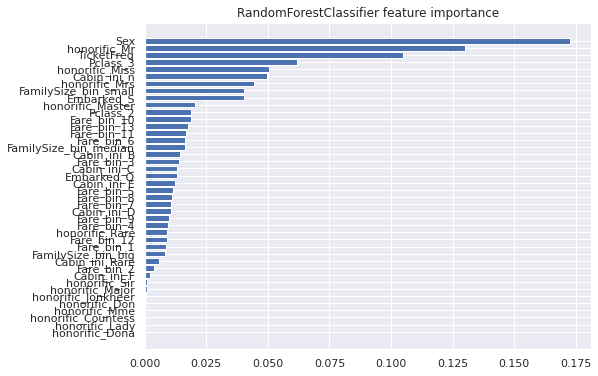

In [ ]:
# RandamForestClassifierの重要度を可視化
plt.figure(figsize=(8,6))
plt.barh(
    X_train.columns[np.argsort(rfc.feature_importances_)],
    rfc.feature_importances_[np.argsort(rfc.feature_importances_)],
    label='RandomForestClassifier'
)
plt.title('RandomForestClassifier feature importance'  )

In [ ]:
!pip install -q optuna

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import optuna

- trial.suggest_discrete_uniform(a, b, c) : 区間[a, b]内を刻み幅cで区切り、最適値を探します
- trial.suggest_uniform(a, b) : 区間[a, b]内で最適値を探す。
- trial.suggest_int(a, b)：int型で調整したいとき。
- trial.suggest_categorical('活性化関数',['relu,'sigmoid'])(活性化関数にrelu or sigmoidのどちらかを選択)

In [ ]:
# RandomForestClassifie

cv = 5

def objective(trial):

    param_grid_rfc = {
        'max_depth':trial.suggest_int('max_depth',5,15),#決定木の深さの最大値を3～10内で選ぶ。値が大きいとほどモデルが複雑で過学習の可能性が高い  
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,5),#葉を構成するのに必要な最小限のサンプルの数
        'min_samples_split':trial.suggest_int('min_samples_split',7,15),#ノードを分割するために必要な最小サンプルサイズ
        'criterion':trial.suggest_categorical('criterion',['gini','entropy']),#デフォルトはgini．その他entropy。この指標を基準にデータを分割
        'max_features':trial.suggest_int('max_features',3,10),#特徴量の選択。大きいと出来る決定木が似て、小さいと異なるものができる
        'random_state':0
    }

    model = RandomForestClassifier(**param_grid_rfc)
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model,X=X_train, y=y_train, cv=kf)

    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials = 100)
print(study.best_params)
print(study.best_value)
rfc_best_param = study.best_params

# {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 14, 'criterion': 'entropy', 'max_features': 6}
# 0.8455136412882893

[I 2021-09-28 05:38:58,361] A new study created in memory with name: no-name-d71ad0e2-60b6-4b2e-af05-c939fe51bc47
[I 2021-09-28 05:38:59,213] Trial 0 finished with value: 0.8342854328769821 and parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 8, 'criterion': 'entropy', 'max_features': 8}. Best is trial 0 with value: 0.8342854328769821.
[I 2021-09-28 05:39:00,114] Trial 1 finished with value: 0.8385107849896583 and parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 14, 'criterion': 'entropy', 'max_features': 7}. Best is trial 1 with value: 0.8385107849896583.
[I 2021-09-28 05:39:00,980] Trial 2 finished with value: 0.8385107849896581 and parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 11, 'criterion': 'entropy', 'max_features': 9}. Best is trial 1 with value: 0.8385107849896583.
[I 2021-09-28 05:39:01,850] Trial 3 finished with value: 0.8300600807643062 and parameters: {'max_depth': 11, 'min_samples_leaf': 3, 'min_s

{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 8, 'criterion': 'gini', 'max_features': 6}
0.8426967398798386


In [ ]:
# trial.suggest_discrete_uniform(a, b, c) : 区間[a, b]内を刻み幅cで区切り、最適値を探します。
# trial.suggest_uniform(a, b) : 区間[a, b]内で最適値を探す。
# trial.suggest_int(a, b)：int型で調整したいとき。
# trial.suggest_categorical('活性化関数',['relu,'sigmoid'])(活性化関数にrelu or sigmoidのどちらかを選択)

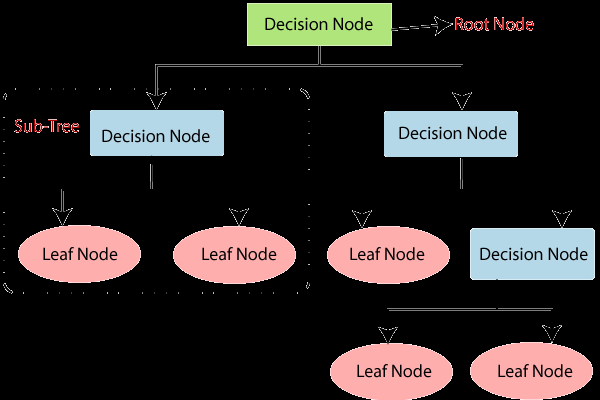

In [ ]:
# XGBoost

def object(trial):

    param_grid_xgb={
        'min_child_weight':trial.suggest_int('min_dhild_weight',1,5),# 決定木の葉の重みの下限を1～5から選ぶ。下限が大きいほど単調な決定木となり、過学習を抑制。
        'gamma':trial.suggest_discrete_uniform('gamma',0.1,1.0,0.1),#決定木の葉の追加による損失減少の下限を区間[a, b]内を刻み幅cで区切り、最適値を探す。値が大きいほどアルゴリズムは保守的。
        'subsample':trial.suggest_discrete_uniform('subsample',0.5,1.0,0.1),#各決定木においてランダムに抽出される標本(データ)の割合を0.5～1.0内で0.1区切りで最適値を探す。小さくすることで過学習を避け、保守的なモデル。
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5,1.0,0.1),#各決定木においてランダムに抽出される列の割合を0.5～1.0内を.01区切りで探す。(説明変数を全て使わずに設定された割合でランダムに抽出された説明変数のみを使用してモデルを作成)
        'max_depth':trial.suggest_int('max_depth',3,10),#決定木の深さの最大値を3～10内で選ぶ。値が大きいとほどモデルが複雑で過学習の可能性が高い                                          

    }
    model = XGBClassifier(**param_grid_xgb)
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)
    scores = cross_validate(model, X_train,y_train,cv=kf)
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)
print(study.best_params)
print(study.best_value)
xgb_best_param = study.best_params
# {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'criterion': 'entropy', 'max_features': 10}
# 0.8427262877967102

[I 2021-09-28 05:40:24,217] A new study created in memory with name: no-name-f7a3f8ba-2694-47fd-9a29-fd648b14d726
[I 2021-09-28 05:40:25,097] Trial 0 finished with value: 0.8328769821727569 and parameters: {'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 12, 'criterion': 'gini', 'max_features': 8}. Best is trial 0 with value: 0.8328769821727569.
[I 2021-09-28 05:40:26,023] Trial 1 finished with value: 0.8342460356544864 and parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 8, 'criterion': 'gini', 'max_features': 10}. Best is trial 1 with value: 0.8342460356544864.
[I 2021-09-28 05:40:26,848] Trial 2 finished with value: 0.8286516300600809 and parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 8, 'criterion': 'gini', 'max_features': 4}. Best is trial 1 with value: 0.8342460356544864.
[I 2021-09-28 05:40:27,659] Trial 3 finished with value: 0.821619225844578 and parameters: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_spl

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 12, 'criterion': 'gini', 'max_features': 4}
0.8441051905840637


In [ ]:
# LightGBM

def objective(trial):

    param_grid_lgb={
        'num_leaves':trial.suggest_int('num_leaves',3,10),#木にある分岐の個数．num_leaves=2max_depth
        'leaning_rate':trial.suggest_loguniform('leaning_rate',1e-8,1.0),#学習率
        'max_depth':trial.suggest_int('max_depth',3,10),#木の深さ
        'random_state':0
    }
    model = LGBMClassifier(**param_grid_lgb)

    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    scores = cross_validate(model, X_train,y_train,cv=kf)
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)
print(study.best_params)
print(study.best_value)
lgb_best_param=study.best_params

# {'num_leaves': 8, 'leaning_rate': 6.324202341622141e-07, 'max_depth': 7}
# 0.8314586821629076

[I 2021-09-28 05:41:48,994] A new study created in memory with name: no-name-2b1fa218-bde0-4173-bdf0-cad290b4a63a
[I 2021-09-28 05:41:49,142] Trial 0 finished with value: 0.8314586821629076 and parameters: {'num_leaves': 8, 'leaning_rate': 0.017546710904440873, 'max_depth': 10}. Best is trial 0 with value: 0.8314586821629076.
[I 2021-09-28 05:41:49,240] Trial 1 finished with value: 0.8188712695754947 and parameters: {'num_leaves': 3, 'leaning_rate': 1.6866821053720866e-05, 'max_depth': 8}. Best is trial 0 with value: 0.8314586821629076.
[I 2021-09-28 05:41:49,364] Trial 2 finished with value: 0.8216487737614498 and parameters: {'num_leaves': 7, 'leaning_rate': 2.2303673984304918e-06, 'max_depth': 6}. Best is trial 0 with value: 0.8314586821629076.
[I 2021-09-28 05:41:49,473] Trial 3 finished with value: 0.8216783216783217 and parameters: {'num_leaves': 4, 'leaning_rate': 0.0013884874371051569, 'max_depth': 10}. Best is trial 0 with value: 0.8314586821629076.
[I 2021-09-28 05:41:49,594]

{'num_leaves': 7, 'leaning_rate': 8.086500159490596e-08, 'max_depth': 4}
0.8370727863685611


In [ ]:
# LogisticRegression

import warnings
warnings.filterwarnings('ignore')

def objective(trial):

    params_grid_lr = {
        'C': trial.suggest_int('C',1,100),
        'random_state':0
    }
    model = LogisticRegression(**params_grid_lr)

    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    score = cross_validate(model,X_train,y_train,cv = kf)
    return score['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=10)
print(study.best_params)
print(study.best_value)
lr_best_param = study.best_params
# {'C': 1}
# 0.8216684723726978

[I 2021-09-28 05:42:01,975] A new study created in memory with name: no-name-a4f5a8ba-0565-45c9-ada8-5d4a62c0a494
[I 2021-09-28 05:42:02,188] Trial 0 finished with value: 0.818851570964247 and parameters: {'C': 2}. Best is trial 0 with value: 0.818851570964247.
[I 2021-09-28 05:42:02,408] Trial 1 finished with value: 0.8160149709445484 and parameters: {'C': 68}. Best is trial 0 with value: 0.818851570964247.
[I 2021-09-28 05:42:02,635] Trial 2 finished with value: 0.8160149709445484 and parameters: {'C': 44}. Best is trial 0 with value: 0.818851570964247.
[I 2021-09-28 05:42:02,847] Trial 3 finished with value: 0.8174234216487738 and parameters: {'C': 75}. Best is trial 0 with value: 0.818851570964247.
[I 2021-09-28 05:42:03,072] Trial 4 finished with value: 0.8174234216487738 and parameters: {'C': 77}. Best is trial 0 with value: 0.818851570964247.
[I 2021-09-28 05:42:03,362] Trial 5 finished with value: 0.8132177681473456 and parameters: {'C': 40}. Best is trial 0 with value: 0.81885

{'C': 2}
0.818851570964247


In [ ]:
#SVC

import warnings
warnings.filterwarnings('ignore')

def objective(trial):

    param_grid_svc = {
        'C':trial.suggest_int('C',50,200),
        'gamma':trial.suggest_loguniform('gamma',1e-4,1.0),
        'random_state':0,
        'kernel':'rbf'
    }

    model = SVC(**param_grid_svc)

    kf = StratifiedKFold(n_splits=5, shuffle=True,random_state=0)

    scores = cross_validate(model,X_train,y_train,cv=kf)

    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=10)
print(study.best_params)
print(study.best_value)
svc_best_param = study.best_params
# {'C': 106, 'gamma': 0.0028613497032236065}
# 0.8385009356840343

[I 2021-09-28 05:42:04,346] A new study created in memory with name: no-name-03678e5b-c990-4df9-8cd9-9e5e3cfdf623
[I 2021-09-28 05:42:04,515] Trial 0 finished with value: 0.8188417216586231 and parameters: {'C': 118, 'gamma': 0.09341259576914678}. Best is trial 0 with value: 0.8188417216586231.
[I 2021-09-28 05:42:04,663] Trial 1 finished with value: 0.796375455530385 and parameters: {'C': 157, 'gamma': 0.00012162085152191223}. Best is trial 0 with value: 0.8188417216586231.
[I 2021-09-28 05:42:04,805] Trial 2 finished with value: 0.8384812370727863 and parameters: {'C': 161, 'gamma': 0.00036376172174740077}. Best is trial 2 with value: 0.8384812370727863.
[I 2021-09-28 05:42:04,957] Trial 3 finished with value: 0.8385009356840343 and parameters: {'C': 65, 'gamma': 0.0038501722690165757}. Best is trial 3 with value: 0.8385009356840343.
[I 2021-09-28 05:42:05,133] Trial 4 finished with value: 0.8385107849896583 and parameters: {'C': 136, 'gamma': 0.012345615100271646}. Best is trial 4 w

{'C': 136, 'gamma': 0.012345615100271646}
0.8385107849896583


In [ ]:
# 汎化性能検証
# 学習データ全体を5分割し、k分割交差検証(Stratified K-Fold CV)を行う

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rfc_best = RandomForestClassifier(**rfc_best_param)
print('RandomForestClassifier')
print('='*20)
scores = cross_validate(rfc_best,X=train_feature,y=train_target,cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20) 

xgb_best = XGBClassifier(**xgb_best_param)
print('XGBClassifier')
print('='*20)
scores = cross_validate(xgb_best,X=train_feature,y=train_target,cv=kf)
print(f'mean:{scores["test_score"].mean()},std:{scores["test_score"].std()}')
print('='*20)

lgb_best = LGBMClassifier(**lgb_best_param)
print('LGBMClassifier')
print('='*20)
scores = cross_validate(lgb_best,X=train_feature,y=train_target,cv=kf)
print(f'mean : {scores["test_score"].mean()},std : {scores["test_score"].std()}')
print('='*20)

lr_best = LogisticRegression(**lr_best_param)
print('LogisticRegression')
print('='*20)
scores = cross_validate(lr_best,X=train_feature,y=train_target,cv=kf)
print(f'mean : {scores["test_score"].mean()},std : {scores["test_score"].std()}')
print('='*20)

svc_best = SVC(**svc_best_param)
print('SVC')
print('='*20)
scores = cross_validate(svc_best,X=train_feature,y=train_target,cv=kf)
print(f'mean : {scores["test_score"].mean()},std : {scores["test_score"].std()}')
print('='*20)

RandomForestClassifier
mean:0.8204130311970372, std:0.019248089976549254
XGBClassifier
mean:0.8114430983616847,std:0.013162963120508863
LGBMClassifier
mean : 0.8103132257862029,std : 0.019698065328495603
LogisticRegression
mean : 0.8204004770573097,std : 0.019342652012936796
SVC
mean : 0.8103132257862029,std : 0.012171486114651181


In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [
              ('rfc',RandomForestClassifier(**rfc_best_param)),
              ('xgb',XGBClassifier(**xgb_best_param)),
              ('lgb',LGBMClassifier(**lgb_best_param)),
              ('lr',LogisticRegression(**lr_best_param)),
              ('svc',SVC(**svc_best_param)),
]
voting = VotingClassifier(estimators)

print('VotingClassifier')
print('='*20)
scores = cross_validate(voting,X=train_feature,y=train_target,cv=kf)
print(f'mean : {scores["test_score"].mean()},std : {scores["test_score"].std()}')

VotingClassifier
mean : 0.8192894356914193,std : 0.012702072358238437


In [ ]:
rfc_best = RandomForestClassifier(**rfc_best_param)
rfc_best.fit(train_feature,train_target)

xgb_best = XGBClassifier(**xgb_best_param)
xgb_best.fit(train_feature,train_target)

lgb_best = LGBMClassifier(**lgb_best_param)
lgb_best.fit(train_feature,train_target)

lr_best = LogisticRegression(**lr_best_param)
lr_best.fit(train_feature,train_target)

svc_best = SVC(**svc_best_param)
svc_best.fit(train_feature,train_target)

pred = {
    'rfc':rfc_best.predict(test_feature),
    'xgb':xgb_best.predict(test_feature),
    'lgb':lgb_best.predict(test_feature),
    'lr':lr_best.predict(test_feature),
    'svc':svc_best.predict(test_feature)
}

for key, value in pred.items():
    pd.concat(
        [
               pd.DataFrame(test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
               pd.DataFrame(value,columns=['Survived'])
        ],axis=1).to_csv(f'output_{key}.csv', index=False)